# HMCによるVAR(2)モデルの推計

In [1]:
import sys

import math

from autograd import grad
import autograd.numpy as np
import scipy.stats as st

import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.api import VAR

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from fredapi import Fred
fred = Fred(api_key='efedf207a63071188c699caf884a4ee9')

In [3]:
#data = fred.get_series('CPIAUCSL').resample('Q').mean()
data_name = ['GDPC1','PCECTPI']
df = pd.DataFrame()
for s in data_name:
    df = pd.concat([df,fred.get_series(s)],axis=1)
df = pd.DataFrame(np.log(df.values),index=list(df.index))      #対数化
df = df.diff().dropna(how='any',axis=0)                        #前期差
cc = pd.DataFrame(np.ones(df.shape[0]),index=list(df.index))
df = pd.concat([df,df.shift(),df.shift(2),cc],axis=1)
df = df.dropna(how='any',axis=0)
df.columns = ['y','p','y1','p1','y2','p2','c']

In [4]:
Y = df.loc[:,['y','p']]
X = df.loc[:,['y1','p1','y2','p2','c']]

In [5]:
Y

,y,p
1947-10-01,0.015521,0.024580
1948-01-01,0.014931,0.011032
1948-04-01,0.016372,0.010304
1948-07-01,0.005713,0.015148
1948-10-01,0.001117,-0.003146
...,...,...
2020-01-01,-0.012707,0.003189
2020-04-01,-0.094158,-0.004039
2020-07-01,0.072123,0.008978
2020-10-01,0.010586,0.003619


In [6]:
X

,y1,p1,y2,p2,c
1947-10-01,-0.002067,0.018455,-0.002670,0.007968,1.0
1948-01-01,0.015521,0.024580,-0.002067,0.018455,1.0
1948-04-01,0.014931,0.011032,0.015521,0.024580,1.0
1948-07-01,0.016372,0.010304,0.014931,0.011032,1.0
1948-10-01,0.005713,0.015148,0.016372,0.010304,1.0
...,...,...,...,...,...
2020-01-01,0.005845,0.003816,0.006349,0.003475,1.0
2020-04-01,-0.012707,0.003189,0.005845,0.003816,1.0
2020-07-01,-0.094158,-0.004039,-0.012707,0.003189,1.0
2020-10-01,0.072123,0.008978,-0.094158,-0.004039,1.0


In [7]:
idx = pd.period_range(start=pd.Period('1947Q4', freq='Q'),
                      end=pd.Period('2021Q1', freq='Q'),
                      freq='Q')

<AxesSubplot:>

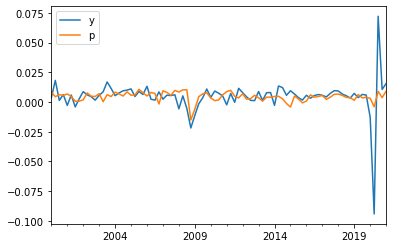

In [8]:
Y.index =idx
Y.loc['2000':].plot()

In [9]:
def forecast_(N,Y,B,sigma2,k):
    yhat = np.zeros((N))
    yhat[0] = Y[-2]
    yhat[1] = Y[-1]
    cfactor = np.sqrt(sigma2)
    for i in range(2,N):
        yhat[i] = np.array([1,yhat[i-1],yhat[i-2]])@B + np.random.randn(1)*cfactor
        
    yhat = pd.DataFrame(yhat,columns=[str(k)])

    return yhat

In [10]:
def leapfrog(q, p, dVdq, path_len, step_size):
    """Leapfrog integrator for Hamiltonian Monte Carlo.

    Parameters
    ----------
    q : np.floatX
        Initial position
    p : np.floatX
        Initial momentum
    dVdq : callable
        Gradient of the velocity
    path_len : float
        How long to integrate for
    step_size : float
        How long each integration step should be

    Returns
    -------
    q, p : np.floatX, np.floatX
        New position and momentum
    """
    q, p = np.copy(q), np.copy(p)

    for _ in range(path_len):
        #print(dVdq(q))
        #sys.exit()
        p -= step_size/2 * dVdq(q)      # half step    (5.31)
        q += step_size * p              # whole step   (5.32)
        p -= step_size/2 * dVdq(q)      # half step   (5.33)
        #print(q)

    #sys.exit()
    # momentum flip at end
    return q, -p

In [11]:
def hamiltonian_monte_carlo(n_samples, dVdq,initial_position, path_len=1, step_size=0.5):#negative_log_prob
    """Run Hamiltonian Monte Carlo sampling.

    Parameters
    ----------
    n_samples : int
        Number of samples to return
    negative_log_prob : callable
        The negative log probability to sample from
    initial_position : np.array
        A place to start sampling from.
    path_len : float
        How long each integration path is. Smaller is faster and more correlated.
    step_size : float
        How long each integration step is. Smaller is slower and more accurate.

    Returns
    -------
    np.array
        Array of length `n_samples`.
    """    
    # autograd magic
    #dVdq = grad(negative_log_prob)

    # collect all our samples in a list
    samples = [initial_position]
    #print('initial position\n', samples)

    # acceptance
    acceptance = 0.0
    
    # Keep a single object for momentum resampling
    momentum = st.norm(0, 1)

    # If initial_position is a 10d vector and n_samples is 100, we want 100 x 10 momentum draws
    # we can do this in one call to np.random.normal, and iterate over rows
    size = (n_samples,) + initial_position.shape[:1] #tuple (n,d)
    for p0 in momentum.rvs(size=size): # 疑似乱数をパラメーター数＊サンプル期間だけ一気に生成
        # Integrate over our path to get a new position and momentum

        q_new, p_new = leapfrog(
            samples[-1],
            p0,
            dVdq,
            path_len=path_len,
            step_size=step_size,
        )
        
        # Check Metropolis acceptance criterion
        start_log_p = negative_log_prob(samples[-1]) - np.sum(momentum.logpdf(p0))
        new_log_p = negative_log_prob(q_new) - np.sum(momentum.logpdf(p_new))
        
        #print(start_log_p,'\n\n',new_log_p)
        #sys.exit()
        if np.log(np.random.rand()) < start_log_p - new_log_p:
            samples.append(q_new)
            acceptance +=1.0
        else:
            samples.append(samples[-1])

    return samples,acceptance/n_samples

In [12]:
def neg_log_mvnormal(mu, sigma):
    """Use a Cholesky decomposition for more careful work."""

    def logp(mu,sigma):
        k = mu.shape[0]
        return (
            k * np.log(2 * np.pi)
            + np.log(np.linalg.det(sigma))
            + (mu@np.linalg.inv(sigma)@mu.T).sum()
        ) * 0.5

    return logp

# ベクトル化

$$
\boldsymbol{Y}_{t} = c + \boldsymbol{B}_{1}\boldsymbol{Y}_{t-1} + \boldsymbol{B}_{2}\boldsymbol{Y}_{t-2} + \cdots + \boldsymbol{B}_{p}\boldsymbol{Y}_{t-p} + v_{t}
$$
<br>
<br>
$$
\boldsymbol{Y}_{t} = \boldsymbol{X}_{t}\boldsymbol{B} + v_{t}
$$
$$ with \quad \boldsymbol{X}_{t} = \left( c_{it},Y_{it-1},Y_{it-2},\cdots,Y_{it-p} \right)$$
<br>
<br>
$$
\boldsymbol{y} = \left( \boldsymbol{I}_N \, \otimes \, \boldsymbol{X} \right) \boldsymbol{b} + \boldsymbol{V}
$$
$$ where \quad \boldsymbol{y} = vec(Y_t), \, \boldsymbol{b} = vec(\boldsymbol{B}), and \,  \boldsymbol{V} = vec(v_t)$$

# QRリパラメタライゼーション

$\boldsymbol{A} =  \left( \boldsymbol{I}_N \, \otimes \, \boldsymbol{X} \right)$として、$\boldsymbol{A}$を$reduced-QR$分解する<br>
<br>
$$
\boldsymbol{A} = \boldsymbol{Q} \boldsymbol{R}
$$
$$
\boldsymbol{y} = \boldsymbol{Q} \boldsymbol{R} \boldsymbol{b} + \boldsymbol{V}
$$
$\boldsymbol{\lambda} = \boldsymbol{R} \boldsymbol{b}$とおくと（リパラメタライゼーション）<br>
$$
\boldsymbol{y} = \boldsymbol{Q} \boldsymbol{\lambda} + \boldsymbol{V}
$$

In [13]:
xlist = ['y1','p1','y2','p2','c']
ylist = ['y','p']
nn = Y.shape[1]

X0 = X.loc[:,xlist].values #縦がN、横がK
XN = (np.kron(np.diag([1]*nn),X0))
Q,R = np.linalg.qr(XN,mode='reduced')
y0 = Y.loc[:,ylist].values.reshape(-1)

In [14]:
print('Y',Y.shape)
print('X0',X0.shape)
print('XN',XN.shape)
print('Q',Q.shape)
print('R',R.shape)
print('y0',y0.shape)

Y (294, 2)
X0 (294, 5)
XN (588, 10)
Q (588, 10)
R (10, 10)
y0 (588,)


In [15]:
n = y0.shape[0]
n_vars = len(ylist)
n_lags = int((len(xlist)-1)/ n_vars)
n_coefs = n_vars * (n_lags*n_vars + 1)
n_params = n_coefs + n_vars # 誤差項間の相関ゼロ

print(nn,n_vars,n_lags,n_coefs,n_params)

2 2 2 10 12


# 対数尤度関数

$$
\log f(\boldsymbol{y}|\boldsymbol{\lambda},\sigma^{2}_{\epsilon}) \, \varpropto \, - n\log\sigma_{\epsilon} - \frac{1}{2\sigma^{2}_{\epsilon}}(\boldsymbol{y}-Q\boldsymbol{\lambda})^T(\boldsymbol{y}-Q\boldsymbol{\lambda})
$$

# Qの事前分布
$$
f(\boldsymbol{Q}|\sigma^{2}_{Q}) \, \varpropto \, \exp \left( - \frac{\boldsymbol{Q}^T\boldsymbol{Q}}{2\sigma^{2}_{Q}} \right)
$$
<br>
ただし、$\boldsymbol{Q}$は多変量正規分布に従い、分散行列は$\sigma^{2}_{Q}\boldsymbol{I}$とする。$\sigma^{2}_{Q}$はハイパーパラメーター

# $\sigma^{2}_{\epsilon}$の事前分布
$$
f(\sigma^{2}_{\epsilon}|a,b) = \frac{b^a}{\Gamma(a)}(\sigma^{2}_{\epsilon})^{-a-1} \exp \left( -\frac{b}{\sigma^{2}_{\epsilon}} \right)
$$
<br>
ただし、$\sigma^{2}_{\epsilon}$は逆ガンマ分布に従い、$a,b$はハイパーパラメーター

ここで、$\sigma^{2}_{\epsilon}$は$(0,\infty)$. これに対してHMCで用いるパラメーター$\theta$の存在領域は、$\theta \in \mathbb{R}$. そこで対数をとる.<br>
<br>
$$
\gamma = \log \sigma^{2}_{\epsilon} \quad \to \quad \sigma^{2}_{\epsilon}=e^{\gamma}
$$
<br>
$$
f(\gamma|a,b) = \frac{b^a}{\Gamma(a)} \exp \left( - a\gamma - \frac{b}{e^{\gamma}} \right)
$$
<br>
$$
\log{f(\gamma|a,b)} \, \varpropto \, - a\gamma - be^{-\gamma}
$$

# 対数事後分布
$$
\log{f(\boldsymbol{\lambda},\gamma|\boldsymbol{y},\boldsymbol{Q},\sigma^{2}_{Q},a,b)} \, \varpropto \, -\left( \frac{n}{2} + a \right)\gamma - \frac{e^{-\gamma}}{2} (\boldsymbol{y}-Q\boldsymbol{\lambda})^T(\boldsymbol{y}-Q\boldsymbol{\lambda}) - \frac{\boldsymbol{Q}^T\boldsymbol{Q}}{2\sigma^{2}_{Q}} - be^{-\gamma}
$$

# ハミルトニアン
$$
H(\boldsymbol{\theta},\boldsymbol{p})=H(\boldsymbol{\lambda},\gamma,\boldsymbol{p}) \, \varpropto \, \log{f(\boldsymbol{\lambda},\gamma|\boldsymbol{y},\boldsymbol{Q},\sigma^{2}_{Q},a,b)} + \frac{1}{2}\boldsymbol{p}^T \boldsymbol{M} \boldsymbol{p}
$$

# $\lambda$による偏微分$\nabla_{\lambda}$
$$
\nabla_{\lambda} \, \varpropto \, e^{-\gamma}\boldsymbol{Q}^T(\boldsymbol{y}-\boldsymbol{Q}\boldsymbol{\lambda})- \frac{1}{\sigma^{2}_{Q}}\boldsymbol{\lambda}
$$

# $\gamma$による偏微分$\nabla_{\gamma}$
$$
\nabla_{\gamma} \, \varpropto \, -\left( \frac{n}{2}+a \right) + \frac{e^{-\gamma}}{2}(\boldsymbol{y}-\boldsymbol{Q}\boldsymbol{\lambda})^T(\boldsymbol{y}-\boldsymbol{Q}\boldsymbol{\lambda}) + be^{-\gamma}
$$

In [16]:
def dVdq(q):
    lambda0 = q[:-1]#.reshape(10,1)
    gamma0 = q[-1]
    
    #ee = (y0-Q@lambda0).reshape(n,1)
    
    nabla_lambda = (math.exp(-gamma0)*(Q.T@(y0-Q@lambda0))-1/sig2q*lambda0)*(-1)
    
    nabla_gamma = (-(n/2 + a) + math.exp(-gamma0)/2*((y0-Q@lambda0).T@(y0-Q@lambda0)) + b*math.exp(-gamma0))*(-1)
    
    return np.hstack([nabla_lambda,nabla_gamma])

# 対数事後分布（再掲）
$$
\log{f(\boldsymbol{\lambda},\gamma|\boldsymbol{y},\boldsymbol{Q},\sigma^{2}_{Q},a,b)} \, \varpropto \, -\left( \frac{n}{2} + a \right)\gamma - \frac{e^{-\gamma}}{2} (\boldsymbol{y}-Q\boldsymbol{\lambda})^T(\boldsymbol{y}-Q\boldsymbol{\lambda}) - \frac{\boldsymbol{Q}^T\boldsymbol{Q}}{2\sigma^{2}_{Q}} - be^{-\gamma}
$$

In [17]:
def negative_log_prob(q):
    lambda0 = q[:-1]#.reshape(10,1)
    gamma0 = q[-1]
    
    ee = (y0-Q@lambda0).reshape(n,1)

    return (-1)*(-(n/2 + a)*gamma0 - math.exp(-gamma0)/2*(ee.T@ee) - (lambda0.T@lambda0)/2/sig2q - b*math.exp(-gamma0))

In [18]:
sig2q = 1e3
a = 1e-4
b = 1e-4

In [19]:
n_samples = 100000
initial_position = np.random.rand(11)/100 # 最初の10つは係数、残りは分散, qの初期値
print(initial_position.shape)

(11,)


In [20]:
#Q = XN

In [21]:
samples,acceptance = hamiltonian_monte_carlo(n_samples, dVdq, initial_position, path_len=100, step_size=0.00001)

In [22]:
acceptance

1.0

<AxesSubplot:>

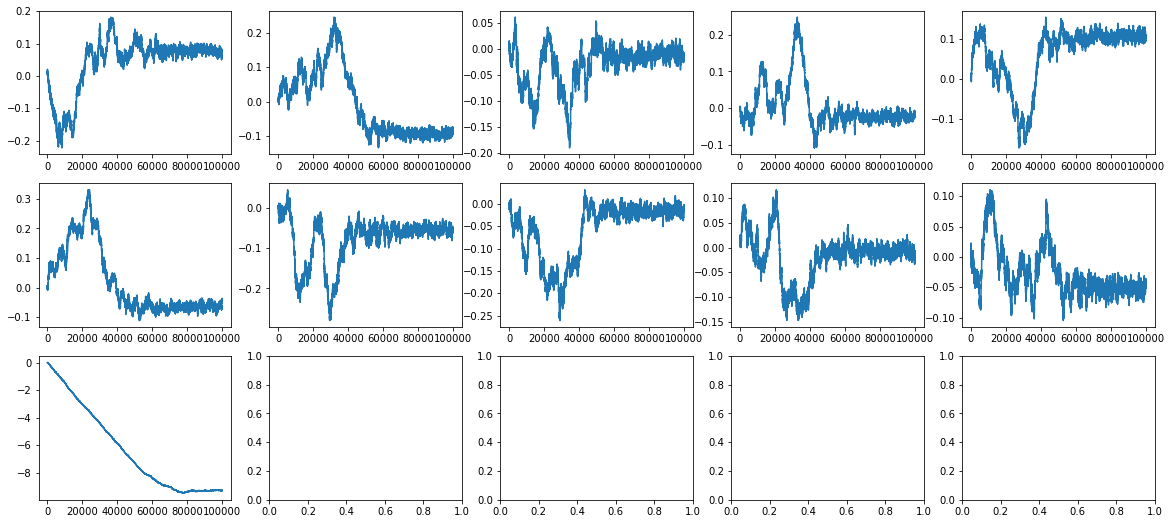

In [23]:
df = pd.DataFrame(samples)

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 9))
df.iloc[:,0].plot(ax=axes[0, 0], legend=False)
df.iloc[:,1].plot(ax=axes[0, 1], legend=False)
df.iloc[:,2].plot(ax=axes[0, 2], legend=False)
df.iloc[:,3].plot(ax=axes[0, 3], legend=False)
df.iloc[:,4].plot(ax=axes[0, 4], legend=False)

df.iloc[:,5].plot(ax=axes[1, 0], legend=False)
df.iloc[:,6].plot(ax=axes[1, 1], legend=False)
df.iloc[:,7].plot(ax=axes[1, 2], legend=False)
df.iloc[:,8].plot(ax=axes[1, 3], legend=False)
df.iloc[:,9].plot(ax=axes[1, 4], legend=False)

df.iloc[:,10].plot(ax=axes[2, 0], legend=False)

# OLSとのパラメーター比較

In [24]:
aa = df.iloc[-1000:,:-1].mean()

X1 = X.loc[:,xlist].values
Y1 = Y.loc[:,ylist].values

model = sm.OLS(y0, Q)
res = model.fit()

aa = pd.concat([aa,pd.DataFrame(res.params.reshape(10,1))],axis=1)
aa.columns = ['HMC','OLS']
aa.index = xlist*2
aa
#print(res.summary())

#(np.linalg.inv(X1.T@X1)@X1.T@Y1).reshape(-1)

,HMC,OLS
y1,0.070591,0.076765
p1,-0.085175,-0.092077
y2,-0.013523,-0.012569
p2,-0.019687,-0.022520
c,0.106526,0.104947
y1,-0.058518,-0.062506
p1,-0.059572,-0.056914
y2,-0.022136,-0.016821
p2,-0.014123,-0.008094
c,-0.046766,-0.051084


# パラメーターの復元

In [25]:
aa = np.linalg.inv(R)@aa
aa.index = xlist*2
aa

,HMC,OLS
y1,-0.069747,-0.052501
p1,0.028038,0.044954
y2,-0.106850,-0.110849
p2,-0.154065,-0.110106
c,0.011169,0.011003
y1,0.024246,0.042625
p1,0.056722,0.111392
y2,0.026968,-0.001029
p2,0.005460,-0.091849
c,0.004903,0.005356


In [26]:
sys.exit()

SystemExit: 

/opt/homebrew/Caskroom/miniforge/base/envs/python38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 復元のチェック

In [ ]:
data_name = ['GDPC1','PCECTPI']
df1 = pd.DataFrame()
for s in data_name:
    df1 = pd.concat([df1,fred.get_series(s)],axis=1)
df1 = pd.DataFrame(np.log(df1.values),index=list(df1.index))      #対数化
df1 = df1.diff().dropna(how='any',axis=0)                        #前期差
df1.columns = ['y','p']

In [ ]:
model = VAR(df1)
model_result = model.fit(maxlags=2, ic='aic')
cc0 = model_result.params
print(cc0,'\n')
cc0 = pd.concat([cc0.iloc[1:,:],pd.DataFrame(cc0.iloc[0,:]).T],axis=0)
#print(cc0,'\n')
cc = (cc0.values).T.reshape(-1).T
#print(pd.DataFrame(cc),'\n')

#bb = pd.concat([bb,pd.DataFrame(cc)],axis=1)
#bb.columns = ['HMC','VAR']
#bb
sys.exit()

In [ ]:
model_result.summary()

In [ ]:
b_ols = pd.DataFrame(np.linalg.inv(XN.T@XN)@(XN.T@y0))
b_qr =pd.DataFrame(np.linalg.inv(R)@(np.linalg.inv(Q.T@Q)@(Q.T@y0)))
pd.concat([b_ols,b_qr],axis=1)

In [ ]:
model = sm.OLS(y0, Q)
res = model.fit()
pd.DataFrame(res.params)

# d次元
尤度関数
\begin{eqnarray}
F(\boldsymbol{y},\boldsymbol{x}|\boldsymbol{b} , \sigma^{2} )=\frac{N}{\sqrt{ (2\pi )^{d} \sigma^{2}}} \exp \left( -\frac{1}{2\sigma^{2}} (\boldsymbol{y} -\boldsymbol{b}\boldsymbol{x} )^{T} (\boldsymbol{y} -\boldsymbol{b}\boldsymbol{x} ) \right) 
\end{eqnarray}

同時事前分布
\begin{eqnarray}
p(\boldsymbol{b},\sigma^{2}) = P(\sigma^{2})\times P(\boldsymbol{b}|\sigma^{2})
\end{eqnarray}

\begin{eqnarray}
P(\sigma^{2}) = (\sigma^{2})^{\frac{T}{2}-1} \exp(-\frac{\theta}{2}\sigma^{2})
\end{eqnarray}

\begin{eqnarray}
P(\boldsymbol{b}|\sigma^{2}) = \frac{1}{\sqrt{ (2\pi )^{K} |\sigma^{2}\Sigma0|}} \exp \left[ -\frac{1}{2}(\boldsymbol{b}-\boldsymbol{b0})^{T} (\sigma^{2}\Sigma0)^{-1}(\boldsymbol{b}-\boldsymbol{b0}) \right]
\end{eqnarray}

同時事後分布



多変量正規分布の対数尤度
\begin{align} 
 L = -\frac{1}{2} \left( d\ln( 2\pi ) + \ln |\boldsymbol{\Sigma}| + (\boldsymbol{y} -\boldsymbol{B}\boldsymbol{x} )^{T} \boldsymbol{\Sigma}^{-1} (\boldsymbol{y} -\boldsymbol{B}\boldsymbol{x} ) \right)\\
\end{align}
ポテンシャルエネルギーは
\begin{align} 
 h(\theta) = -L
\end{align}
ポテンシャルエネルギーの母数による微分
\begin{eqnarray}
 \frac{\partial h}{\partial \theta} = \left(\frac{\partial h}{\partial \boldsymbol{B}},\frac{\partial h}{\partial \boldsymbol{\Sigma}}\right)
\end{eqnarray}

\begin{eqnarray}
\frac{\partial h}{\partial \boldsymbol{B}} &=&  -\boldsymbol{x}(\boldsymbol{y} -\boldsymbol{B}\boldsymbol{x} )^{T} \boldsymbol{\Sigma}^{-T}\\
\frac{\partial h}{\partial \boldsymbol{\Sigma}} &=&  \frac{1}{2} \left[ \boldsymbol{\Sigma}^{-T}-  \boldsymbol{\Sigma}^{-2}(\boldsymbol{y} -\boldsymbol{B}\boldsymbol{x}) (\boldsymbol{y} -\boldsymbol{B}\boldsymbol{x})^{T}) \right]
\end{eqnarray}

\begin{eqnarray}
A^{-1}A=I 
\end{eqnarray}

\begin{eqnarray}
\frac{\partial A^{-1}}{\partial A}A+A^{-1}\frac{\partial A}{\partial A}=0 
\end{eqnarray}

\begin{align}
\frac{\partial A^{-1}}{\partial A} &= -A^{-1}\frac{\partial A}{\partial A}A^{-1} \nonumber \\
    &= -A^{-1}A^{-1}
\end{align}

\begin{eqnarray}
\frac{\partial \ln |A|}{\partial A} = (A^{-1})^{T} 
\end{eqnarray}

In [ ]:
sig0 = np.array([[5,0],[0,3]])
y = np.array([[10],[5]])
x = np.array([[0.5],[5],[2]])
B0 = np.array([[1,0.5],[0.3,0.01],[0.6,0.8]])
def F(x,y):
    sig = np.diag([x,y])
    return -0.5*(np.log(np.linalg.det(sig))#+(y-B.T@x).T@sig0@(y-B.T@x))

In [ ]:
a = np.linalg.inv(X.T.values@X.values)@(X.T.values@Y.values)
q = np.vstack([a.reshape(10,1),np.array([[0.1],[0.5]])])
q.reshape(12,)

In [ ]:


#q = np.array([4.13476899, 2.86026605, 9.89844   , 1.01637184, 2.83090892,
#     0.81318511, 9.01138825, 5.74634942, 7.14933043, 2.13098425,
#     4.37816492, 1.99361286])
#q.shape# = q.reshape(12,)

In [ ]:
dVdq(q.reshape(12,))#.shape

In [ ]:
np.diag(q[n_coefs:].tolist())

In [ ]:
(X0.T@Y0@np.diag([0.01,0.02]))

In [ ]:
X = np.array([[1,0.5],[2,1.5],[3,2.2]])
X

In [ ]:
B = np.array([[0.1,0.2],[0.02,0.01]])
B

In [ ]:
np.diag([1]*4)

In [ ]:
X@B

In [ ]:
(X@B).T.reshape(-1)

In [ ]:
B.T.reshape(-1)@(np.kron(np.diag([1]*2),X)).T